# A DSL alongside a Genetic Algorithm applied to the ARC Dataset

In this notebook, we present a minimalistic *Domain Specific Language* for some of the ARC tasks.

We instroduce the language and how it can be used to precess the input in complex ways. We then implement an evaluation function able to run a such program against an input image. We also provide a program solution of a task as an exemple.

In a second time, we implement a simple genetic algorithm (based on a multiobjective and elitist strategy) that is able to generate programs written in this DSL and demonstrate its usage against the same ARC task previously solved by hand.

In [4]:
# def solve_46f33fce(I):
#     x1 = rot180(I)
#     x2 = downscale(x1, TWO)
#     x3 = rot180(x2)
#     O = upscale(x3, FOUR)
#     return O

#arc-agi-2

# def solver(input):
#     bottom_right = input
#     top_right = dsl.hmirror(bottom_right)
#     top_left = dsl.vmirror(top_right)
#     bottom_left = dsl.vmirror(bottom_right)
#     top = dsl.hconcat(top_left, top_right)
#     bottom = dsl.hconcat(bottom_left, bottom_right)
#     output = dsl.vconcat(top, bottom)
#     return output

# def solver_0c786b71(I):
#     x1 = hmirror(I)
#     x2 = vmirror(x1)
#     x3 = vmirror(I)
#     x4 = hconcat(x2,x1)
#     x5 = hconcat(x3,I)
#     O = vconcat(x4,x5)
# return O
#[hmirror, vmirror, vmirror, hconcat, hconcat, vconcat]

#given by vinayak

# def solver_1(I):
#   x1 = circular_shift_rows(I)
#   x2 = rot90(x1)
#   x3 = upscale(x2)
#   return x3

# def solver_2(I):
#   x1 = rot90(I)
#   x2 = upscale(x1)
#   x3 = tophalf(x2)
#   return x3

# def solver_3(I):
#   x1 = hmirror(I)
#   x2 = tophalf(x1)
#   x3 = circular_shift_rows(x2)
#   return x3

# def solver_4(I):
#   x1 = circular_shift_rows(I)
#   x2 = downscale_2(x1)
#   x3 = vmirror(x2)
#   return x3

In [5]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <span style="color:red">If you like the content of this notebook, please consider upvoting it.</span>

Not only it will show to visitors that this notebook have valuable information, but it will also encourage me to produce more quality notebooks. :)

In [6]:
# Usual numpy, panda, matplotlib and python libraries imports
import numpy as np
import pandas as pd
import itertools
import random

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors

data_path = Path('/content/drive/MyDrive/ARC DATA/ARC-AGI/data')
training_path = data_path / 'training'

training_tasks = sorted(os.listdir(training_path))

In [7]:
!git clone https://github.com/michaelhodel/arc-dsl.git
import sys
sys.path.append('/content/arc-dsl')

Cloning into 'arc-dsl'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 270 (delta 163), reused 135 (delta 135), pack-reused 98 (from 1)
Receiving objects: 100% (270/270), 457.74 KiB | 18.31 MiB/s, done.
Resolving deltas: 100% (168/168), done.


# Domain Specific Language (DSL)

We will build a domain specific language specialized on processing list of images. To allow easy chaining of keyword from this language together, each *function* provided by this language will be take one or more images and transform it to none, one or more. The final result of our program will then be a list of images.

The DSL is so constituted by a collection of functions of type `np.array -> [np.array]` and `[np.array] -> [np.array]`.

The first kind of function take an image, and produce a list of images (for example, the image split by different colors). The second type of function take a list of images and produce a new list (for exemple, intersect).
[](http://)

## DSL Implementation

We start with the functions that take *one image* and produce an *a list of images*.](http://)

In [8]:
# # np.array -> [np.array]
# def groupByColor_unlifted(pixmap):
#     """ Split an image into a collection of images with unique color """
#     # Count the number of colors
#     nb_colors = int(pixmap.max()) + 1
#     # Create a pixmap for each color
#     splited = [(pixmap == i) * i for i in range(1, nb_colors)]
#     # Filter out empty images
#     return [x for x in splited if np.any(x)]

# # np.array -> [np.array]
# def cropToContent_unlifted(pixmap):
#     """ Crop an image to fit exactly the non 0 pixels """
#     # Op argwhere will give us the coordinates of every non-zero point
#     true_points = np.argwhere(pixmap)
#     if len(true_points) == 0:
#         return []
#     # Take the smallest points and use them as the top left of our crop
#     top_left = true_points.min(axis=0)
#     # Take the largest points and use them as the bottom right of our crop
#     bottom_right = true_points.max(axis=0)
#     # Crop inside the defined rectangle
#     pixmap = pixmap[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
#     return [pixmap]

# # np.array -> [np.array]
# def splitH_unlifted(pixmap):
#     """ Split horizontally an image """
#     h = pixmap.shape[0]
#     if h % 2 == 1:
#         h = h // 2
#         return [pixmap[:h,:], pixmap[h+1:,:]]
#     else:
#         h = h // 2
#         return [pixmap[:h,:], pixmap[h:,:]]

# # np.array -> [np.array]
# def negative_unlifted(pixmap):
#     """ Compute the negative of an image (and conserve the color) """
#     negative = np.logical_not(pixmap).astype(int)
#     color = max(pixmap.max(), 1)
#     return [negative * color]

# from dsl import *
from constants import *
from arc_types import *

import numpy as np


def rot180(grid: np.array) -> np.array:
    """ half rotation """
    # Convert the np.array to a tuple of tuples for processing
    grid_tuple = tuple(tuple(row) for row in grid)

    # Process the grid as a tuple (the original logic)
    rotated = tuple(tuple(row[::-1]) for row in grid_tuple[::-1])  # Rotate 180 degrees (reverse rows and columns)

    # Convert the result back to a NumPy array
    return [np.array(rotated)]


def upscale_4(element: np.array) -> np.array:
    """ upscale object or grid """
    factor = 4
    # Convert the np.array to a tuple of tuples for processing
    if isinstance(element, np.ndarray):
        element_tuple = tuple(tuple(row) for row in element)

        # Process the grid (original logic in tuple format)
        g = tuple()
        for row in element_tuple:
            upscaled_row = tuple()
            for value in row:
                upscaled_row = upscaled_row + tuple(value for num in range(factor))
            g = g + tuple(upscaled_row for num in range(factor))

        # Convert the result back to NumPy array
        return [np.array(g)]
    else:
        if len(element) == 0:
            return frozenset()
        di_inv, dj_inv = ulcorner(element)
        di, dj = (-di_inv, -dj_inv)
        normed_obj = shift(element, (di, dj))
        o = set()
        for value, (i, j) in normed_obj:
            for io in range(factor):
                for jo in range(factor):
                    o.add((value, (i * factor + io, j * factor + jo)))
        return [shift(frozenset(o), (di_inv, dj_inv))]


def downscale_2(grid: np.array) -> np.array:
    """ downscale grid """
    factor = 2
    # Convert np.array to tuple of tuples for processing
    grid_tuple = tuple(tuple(row) for row in grid)

    # Process the grid as a tuple (original logic for downscaling)
    h, w = len(grid_tuple), len(grid_tuple[0])
    g = tuple()
    for i in range(h):
        r = tuple()
        for j in range(w):
            if j % factor == 0:
                r = r + (grid_tuple[i][j],)
        g = g + (r, )

    # Downscale grid by selecting every `factor`-th row
    h = len(g)
    dsg = tuple()
    for i in range(h):
        if i % factor == 0:
            dsg = dsg + (g[i],)

    # Convert the result back to NumPy array
    return [np.array(dsg)]



#new examples by vinayak

def grid_to_tuple(grid: np.ndarray) -> tuple:
    """Convert a 2D NumPy array to a tuple of tuples."""
    return tuple(tuple(row) for row in grid)

def tuple_to_grid(grid: tuple) -> np.ndarray:
    """Convert a tuple of tuples back to a 2D NumPy array."""
    return np.array([list(row) for row in grid])

def circular_shift_rows(grid: np.ndarray) -> np.ndarray:
    """Circularly shift rows up by one position."""
    grid_tuple = grid_to_tuple(grid)
    shifted_grid = grid_tuple[1:] + grid_tuple[:1] if grid_tuple else grid_tuple
    return [tuple_to_grid(shifted_grid)]

def rot90(grid: np.ndarray) -> np.ndarray:
    """Rotate grid 90 degrees clockwise."""
    grid_tuple = grid_to_tuple(grid)
    rotated_grid = tuple(zip(*grid_tuple[::-1]))
    return [tuple_to_grid(rotated_grid)]

def upscale(grid: np.ndarray) -> np.ndarray:
    """Upscale grid by a factor of 2 (modified version)."""
    grid_tuple = grid_to_tuple(grid)
    upscaled_grid = tuple(
        tuple(val for val in row for _ in range(2))
        for row in grid_tuple
        for _ in range(2)
    )
    return [tuple_to_grid(upscaled_grid)]

# def downscale_2(grid: np.ndarray) -> np.ndarray:
#     """Downscale grid by a factor of two."""
#     grid_tuple = grid_to_tuple(grid)
#     factor = 2
#     h, w = len(grid_tuple), len(grid_tuple[0])
#     g = tuple()
#     for i in range(h):
#         r = tuple()
#         for j in range(w):
#             if j % factor == 0:
#                 r = r + (grid_tuple[i][j],)
#         g = g + (r,)
#     h = len(g)
#     dsg = tuple()
#     for i in range(h):
#         if i % factor == 0:
#             dsg = dsg + (g[i],)
#     return [tuple_to_grid(dsg)]

def hmirror(piece: np.ndarray):
    """Mirror the grid along the horizontal axis"""
    return [np.flipud(piece)]

def vmirror(piece: np.ndarray):
    """Mirror the grid along the vertical axis"""
    return [np.fliplr(piece)]

def tophalf(grid: np.ndarray):
    """Return the upper half of the grid"""
    return [grid[:len(grid) // 2]]

We now write functions that take a list of images and transform it to a new list.

In [9]:
# [np.array] -> [np.array]
def identity(x):
    return x

# [np.array] -> [np.array]
def tail(x):
    if len(x) > 1:
        return x[1:]
    else:
        return x

# [np.array] -> [np.array]
def init(x):
    if len(x) > 1:
        return x[:1]
    else:
        return x

# [np.array] -> [np.array]
def union(x):
    """ Compute the pixel union of all images in the list. """
    if len(x) < 2:
        return x

    # Make sure everybody have the same shape
    first_shape = tuple(x[0].shape)
    for pixmap in x[1:]:
        if first_shape != tuple(pixmap.shape):
            return []

    return [np.bitwise_or.reduce(np.array(x).astype(int))]

def intersect(x):
    """ Compute the pixel intersection of all images in the list. """
    if len(x) < 2:
        return x

    # Make sure everybody have the same shape
    first_shape = tuple(x[0].shape)
    for pixmap in x[1:]:
        if first_shape != tuple(pixmap.shape):
            return []

    return [(np.prod(np.array(x), axis=0) > 0).astype(int)]

def sortByColor(xs):
    """ Sort pictures by increasing color id. """
    xs = [x for x in xs if len(x.reshape(-1)) > 0]
    return list(sorted(xs, key=lambda x: x.max()))

def sortByWeight(xs):
    """ Sort images by how many non zero pixels are contained. """
    xs = [x for x in xs if len(x.reshape(-1)) > 0]
    return list(sorted(xs, key=lambda x: (x>0).sum()))

def reverse(x):
    """ Reverse the order of a list of images. """
    return x[::-1]


## Composition of functions

It is important to make sure we can chain both functions. To compose two functions `f` and `g` of type `[np.array] -> [np.array]` ; We symply call `g(f([input_image]))`.


But for each function of the type `np.array -> [np.array]` some work is required. We need to generated a *lifted version* version of them. A function `f: np.array -> [np.array]` can be turned into a function of type `[np.array] -> [np.array]` by applying `f` on each image of the input list and concatenating the results.

---
If you want to know more about the `lift` concept, have a look to the concept of [*monades*](https://en.wikipedia.org/wiki/Monad_%28functional_programming%29). We are indeed using the *list monade*.

In [10]:
def lift(fct):
    # Lift the function
    def lifted_function(xs):
        list_of_results = [fct(x) for x in xs]
        return list(itertools.chain(*list_of_results))
    # Give a nice name to the lifted function
    import re
    lifted_function.__name__ = re.sub('_unlifted$', '_lifted', fct.__name__)
    return lifted_function

# cropToContent = lift(cropToContent_unlifted)
# groupByColor = lift(groupByColor_unlifted)
# splitH = lift(splitH_unlifted)
# negative = lift(negative_unlifted)

upscale_4 = lift(upscale_4)
downscale_2 = lift(downscale_2)
rot180 = lift(rot180)

circular_shift_rows = lift(circular_shift_rows)
upscale = lift(upscale)
rot90 = lift(rot90)
# downscale_2 = lift(downscale_2)
hmirror = lift(hmirror)
vmirror = lift(vmirror)
tophalf = lift(tophalf)

# Task

We now load a simple task and execute one of our functions on it.

In [11]:
#
# This code is used to display a task
#

cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
def plot_one(ax, i,train_or_test,input_or_output):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)

    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)


def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):
        plot_one(axs[0,i],i,'train','input')
        plot_one(axs[1,i],i,'train','output')
    plt.tight_layout()
    plt.show()

    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1:
        plot_one(axs[0],0,'test','input')
        plot_one(axs[1],0,'test','output')
    else:
        for i in range(num_test):
            plot_one(axs[0,i],i,'test','input')
            plot_one(axs[1,i],i,'test','output')
    plt.tight_layout()
    plt.show()


# Display each output of the function
def show_image_list(images):
    """ Show each image contained in a list. """
    p = plt.figure().subplots(1, len(images))
    if len(images) > 1:
        for i, image in enumerate(images):
            p[i].imshow(image, cmap=cmap, norm=norm)
    elif len(images) == 1:
        p.imshow(images[0], cmap=cmap, norm=norm)


/content/drive/MyDrive/ARC DATA/ARC-AGI/data/training/46f33fce.json


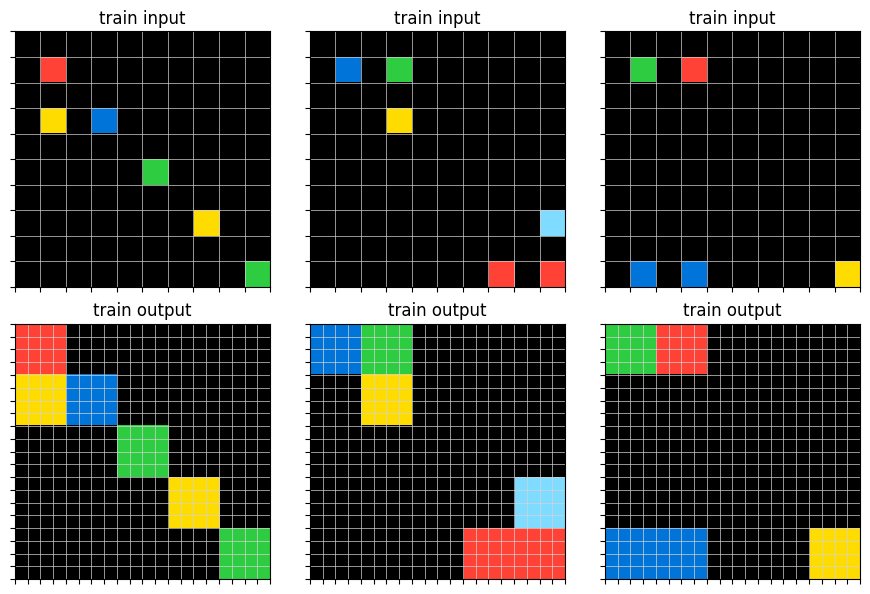

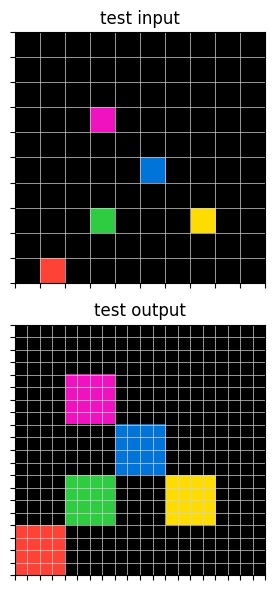

In [12]:
# Load my favorite task
task_file = str(training_path / "46f33fce.json")
print(task_file)
with open(task_file, 'r') as f:
    task = json.load(f)
    plot_task(task)

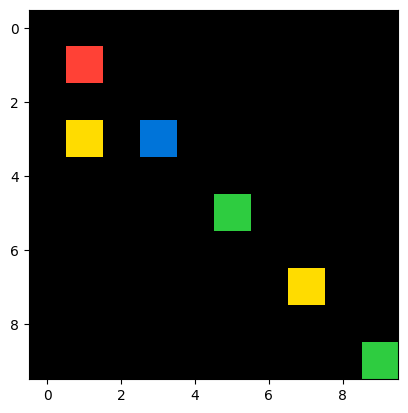

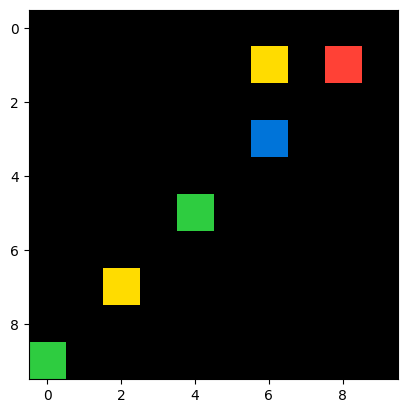

In [13]:
# Execute the group by color on the first input
input_image = np.array(task['train'][0]['input'])
show_image_list([input_image])
images = rot90([input_image])
# Show the result of our function
show_image_list(images)

# Program evaluation


We define our building blocks for programs (the functions in our DSL). We will define a program as a list of functions from our DSL ; `program: [[np.array] -> [np.array]]`. The instructions in our programs will be executed *from left to right*. This mean that if we want to first `splitByColor` and then compute the `negative` of the image, we need to write `[splitByColor, negative]` in this order.

Let's first write an utilitary function to describe a program as a human readable string.

In [14]:
def program_desc(program):
    """ Create a human readable description of a program. """
    desc = [x.__name__ for x in program]
    return(' >> '.join(desc))

# Display the program description alongside its output
program = [rot180, downscale_2,rot180, upscale_4]
print(program_desc(program))

rot180 >> downscale_2 >> rot180 >> upscale_4


## The evaluation method
We want to run and evaluate a such program on a pictures and then recover the result. This logic is realised by the `evaluate` function.

In [15]:
def evaluate(program: [], input_image: np.array):
    # Make sure the input is a np.array
    input_image = np.array(input_image)
    assert type(input_image) == np.ndarray

    # Apply each function on the image
    image_list = [input_image]
    for fct in program:
        # Apply the function
        image_list = fct(image_list)
        # Filter out empty images
        image_list = [img for img in image_list if img.shape[0] > 0 and img.shape[1] > 0]
        # Break if there is no data
        if image_list == []:
            return []
    return image_list

## Simple test on a task
We apply the simple program `[groupByColor, negative]` on the task we loaded earlier.

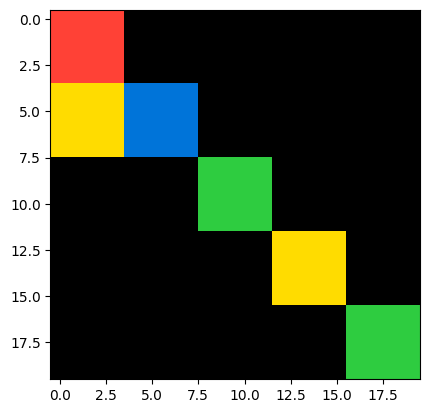

In [16]:
results = evaluate(program=[rot180, downscale_2,rot180, upscale_4], input_image=task['train'][0]['input'])
show_image_list(results)
# def solve_46f33fce(I):
#     x1 = rot180(I)
#     x2 = downscale(x1, TWO)
#     x3 = rot180(x2)
#     O = upscale(x3, FOUR)
#     return O

# Program generation (Genetic Algorithm)

We now have a simple and powerful language to express various transformation on images. But someone or something still have to write the actual program that can solve a task. In this part, we will implement a naive but somewhat efficient genetic algorithm that will be able to find by itself the solution to a task.

The strategy will be as follow:

* We generate random program with one node, and then run them. We keep the best solution (the *elites* of our population).
* Starting from this best solutions, we create new program though mutation. We avaluate them again and update our collection of elite.
* We continue doing this process again and again... until a solution is found.

---

Since we use multiple fitness function, our aproache can be qualified of [multi-objectives](https://en.wikipedia.org/wiki/Multi-objective_optimization) : we try to optimise multiple objectives at the same time.

Our *elites* can be understood as an approximation of the pareto surface (collection of pareto optimal solution). In our specific case, when a solution to the task exists in our DSL, their exists a global minimum that will be smaller than any candidate. In a such case the pareto surface is reduced to a single point. Nethertheless, this is a good image to keep in mind to understand what the collection of *elites* represent.

## Is a program solution ?

First, we need a way to know if a program is a solution of the given examples of a task.

In [17]:
def are_two_images_equals(a, b):
    if tuple(a.shape) == tuple(b.shape):
        if (np.abs(b-a) < 1).all():
            return True
    return False

def is_solution(program, task, verbose=True):
    for sample in task: # For each pair input/output
        i = np.array(sample['input'])
        o = np.array(sample['output'])

        # Evaluate the program on the input
        images = evaluate(program, i)
        if len(images) < 1:
            return False

        # The solution should be in the 3 first outputs
        images = images[:3]

        # Check if the output is in the 3 images produced
        is_program_of_for_sample = any([are_two_images_equals(x, o) for x in images])
        if not is_program_of_for_sample:
            return False

    return True

program = [rot180, downscale_2,rot180, upscale_4]
print(program_desc(program),"is a solution of the task:", is_solution(program, task['train']))

rot180 >> downscale_2 >> rot180 >> upscale_4 is a solution of the task: True


## Fitness

To help our algorithm progress in the right direction, we need a way to give a score to an existing program. The smaller is the score of the program, the closer we are to the solution. One can think of this score as a distance of our program to the optimal solution.

Notice that one can think of this program as a minimization problem (minimize `score`) or maximization problem (minimize `-score`). On machine learning it is common to minimise a distance wereas in genetic algorithm literature you can read that we maximize the fitness of an agent^1. Both convention work perfectly, but it is more convenient if we choose one and stick to it. Therefore, we will MINIMIZE the score of our programs.

Because we can't really comme up with one single good score function that would describe well the progression of the algorithm on all task of the dataset, we will evaluate how our program perform on different aspects through a collection of them.

---

^1: The reason you see maximization and positive score in Genetic Programming literature is that you need all your values to be positive in order to build a probability distribution over your population. Since we use an elitist algorithm instead of a sampling of the population for reproduction, we do not need this restriction.

In [18]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import json


# Load the VGG16 model (pre-trained on ImageNet)
vgg16 = models.vgg16(pretrained=True).features
vgg16 = vgg16.eval()  # Set to evaluation mode (no training)

# Freeze the parameters in the VGG model (don't update weights)
for param in vgg16.parameters():
    param.requires_grad = False

# Define a function to extract features from VGG16
def extract_vgg_features(image, layers=[0, 5, 10, 19, 28]):
    """
    Extract features from specific layers of VGG16.
    Args:
    - image (Tensor): Input image of shape (B, C, H, W)
    - layers (list): List of layer indices to extract features from

    Returns:
    - features (list): List of feature maps at specified layers
    """
    features = []
    x = image
    for i, layer in enumerate(vgg16):
        x = layer(x)
        if i in layers:
            features.append(x)
    return features

# Define the VGG loss function
def vgg_loss(generated_image, target_image, layers=[0, 5, 10, 19, 28]):
    """
    Calculate VGG loss between the generated image and the target image.

    Args:
        generated_image (Tensor): Generated image (Tensor of shape (B, C, H, W)).
        target_image (Tensor): Ground truth image (Tensor of shape (B, C, H, W)).
        layers (list): List of layer indices to compute loss on.

    Returns:
        loss (Tensor): Calculated VGG loss (L2 distance between feature maps).
    """
    # Pass both images through VGG to get feature maps at different layers
    generated_features = extract_vgg_features(generated_image, layers)
    target_features = extract_vgg_features(target_image, layers)

    # Initialize the loss
    loss = 0
    for gen_feat, target_feat in zip(generated_features, target_features):
        # Calculate L2 loss between feature maps (mean squared error)
        loss += torch.nn.functional.mse_loss(gen_feat, target_feat)

    return loss

# Function to convert a grid of integers (0-9) into an image
def grid_to_image(grid, color_map=None):
    """
    Convert a grid of integers (representing colors) into an image (RGB).

    Args:
        grid (numpy.ndarray): 2D array representing the grid of colors.
        color_map (list of tuples): List of RGB tuples representing each color.

    Returns:
        image (PIL.Image): The image generated from the grid.
    """
    # If color_map is not provided, create a default one where each color is assigned a unique RGB value
    if color_map is None:
        color_map = [(i * 28, i * 28, i * 28) for i in range(10)]  # Grayscale colors for 10 values

    # Convert grid to RGB by mapping each integer in the grid to its corresponding RGB value
    rgb_grid = np.array([color_map[pixel] for row in grid for pixel in row], dtype=np.uint8)
    rgb_grid = rgb_grid.reshape((len(grid), len(grid[0]), 3))  # Reshape to (height, width, 3)

    # Convert to a PIL image
    image = Image.fromarray(rgb_grid)
    return image

# Define image pre-processing and loading functions
def preprocess_image(image, size=(224, 224)):
    """
    Preprocess image to the format suitable for VGG16 input (ImageNet format).

    Args:
        image (PIL.Image): Input image (height, width, 3).
        size (tuple): Size to resize the image.

    Returns:
        Tensor: Preprocessed image as a tensor of shape (B, C, H, W).
    """
    preprocess = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension (B, C, H, W)

    return image

# # Example Usage:
# # Load the JSON data (assuming the JSON is stored in 'image_data.json')
# with open('/content/drive/MyDrive/arc_agi/training/46f33fce.json', 'r') as f:
#     data = json.load(f)

# # Extract the input and output grids (assuming the JSON contains a list of 'train' examples)
# input_image = data['train'][0]['input']
# output_image = data['train'][0]['output']

# print(f'step_1: {input_image}')

# # Convert grids to images
# input_image_pil = grid_to_image(input_image)
# output_image_pil = grid_to_image(output_image)

# print(f'step_2: {input_image_pil}')
# # Preprocess images
# input_tensor = preprocess_image(input_image_pil)
# output_tensor = preprocess_image(output_image_pil)

# print(f'step_3: {input_tensor}')
# # Calculate the VGG loss between the input and output images
# loss = vgg_loss(input_tensor, output_tensor)
# print(f"VGG Loss between the input and output: {loss.item()}")


def fitness_1(p,e):
  # input_tensor = torch.tensor(p)
  # output_tensor = torch.tensor(e)

  input_image_pil = grid_to_image(p)
  output_image_pil = grid_to_image(e)

  input_tensor = preprocess_image(input_image_pil)
  output_tensor = preprocess_image(output_image_pil)

  return vgg_loss(input_tensor, output_tensor)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 154MB/s]


In [19]:
def width_fitness(predicted, expected_output):
    """ How close the predicted image is to have the right width. Less is better."""
    return np.abs(predicted.shape[0] - expected_output.shape[0])

def height_fitness(predicted, expected_output):
    """ How close the predicted image is to have the right height. Less is better."""
    return np.abs(predicted.shape[1] - expected_output.shape[1])

def activated_pixels_fitness(p, e):
    """ How close the predicted image to have the right pixels. Less is better."""
    shape = (max(p.shape[0], e.shape[0]), max(p.shape[1], e.shape[1]))
    diff = np.zeros(shape, dtype=int)
    diff[0:p.shape[0], 0:p.shape[1]] = (p > 0).astype(int)
    diff[0:e.shape[0], 0:e.shape[1]] -= (e > 0).astype(int)

    return (diff != 0).sum()

def colors_fitness(p, e):
    p_colors = np.unique(p)
    e_colors = np.unique(e)

    nb_inter = len(np.intersect1d(p_colors, e_colors))

    return (len(p_colors) - nb_inter) + (len(e_colors) - nb_inter)


import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from skimage.transform import resize  # Import resize from skimage

def cosine_similarity_fitness(predicted, expected_output):
    """
    Calculate cosine similarity between the flattened predicted and expected images.
    Resize images if they have different dimensions.
    Higher similarity is better.
    """
    # If the dimensions are different, resize the expected image to match the predicted one
    if predicted.shape != expected_output.shape:
        expected_output_resized = resize(expected_output, predicted.shape, mode='reflect')
    else:
        expected_output_resized = expected_output

    # Flatten both images to 1D vectors
    predicted_flat = predicted.flatten().reshape(1, -1)
    expected_flat = expected_output_resized.flatten().reshape(1, -1)

    # Compute cosine similarity between the two flattened vectors
    similarity = cosine_similarity(predicted_flat, expected_flat)

    # Cosine similarity is between -1 and 1, we want "less is better", so we subtract from 1
    # This ensures that a higher similarity value results in a lower fitness score
    return 1 - similarity[0][0]  # Since similarity is 1D, we get the first element


fitness_functions = [colors_fitness, activated_pixels_fitness, height_fitness, width_fitness]
# fitness_functions = [colors_fitness, fitness_1, height_fitness, width_fitness]
# fitness_functions = [fitness_1]

The fitness score (less is better) of our function will be a 4-dimensional tuple containing the result of each of the fitness functions.

We want to be able to compare two score. Unfortunately, the *lixocographical order* is not adapted, as there is no reason than having a small `width score` is better than having a small `height score`. We are going to define a partial order that give the same weight to any fitness function.

When we compare two tuple with this partial order, `(3, 2, 4, 0) < (3, 2, 5, 0)` and `(3, 2, 4, 0) < (4, 2, 4, 0)`. But there is no way to compare `(3, 2, 5, 0)` and `(4, 2, 4, 0)`. We say this two values are *incomparable*. If two score are incomparable, it means that we cannot say that one program is better than the over.

In [20]:
def product_less(a, b):
    """ Return True iff the two tuples a and b respect a<b for the partial order. """
    a = np.array(a)
    b = np.array(b)
    return (np.array(a) < np.array(b)).all()


We now write a function that evaluate the fitness of a program on a task.

In [21]:
# ([[np.array] -> [np.array]], Taks) -> (int, int, ..., int)
def evaluate_fitness(program, task):
    """ Take a program and a task, and return its fitness score as a tuple. """
    score = np.zeros((len(fitness_functions)))

    # For each sample
    for sample in task:
        i = np.array(sample['input'])
        o = np.array(sample['output'])

        # For each fitness function
        for index, fitness_function in enumerate(fitness_functions):
            images = evaluate(program, i)
            if images == []: # Penalize no prediction!
                score[index] += 500
            else: # Take only the score of the first output
                score[index] = fitness_function(images[0], o)
    return tuple(score)

print("Fitness evaluation:", evaluate_fitness([rot180, downscale_2,rot180, upscale_4], task['train']))

Fitness evaluation: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0))


## Asexual reproduction

Now that we can compare two programs we need a way to generate some of them. We will generate them randomly from a pool of best candidate.

For the initial run, and also to be able to evaluate fresh candidates, we will also allow spontaneous generation of new born one instruction programs.

In [22]:
def build_candidates(allowed_nodes=[identity], best_candidates=[], nb_candidates=200):
    """
    Create a poll of fresh candidates using the `allowed_nodes`.

    The pool contain a mix of new single instructions programs
    and mutations of the best candidates.
    """
    new_candidates = []
    length_limit = 5 # Maximal length of a program

    def random_node():
        return random.choice(allowed_nodes)

    # Until we have enougth new candidates
    while(len(new_candidates) < nb_candidates):
        # Add 10 new programs
        for i in range(5):
            new_candidates += [[random_node()]]

        # Create new programs based on each best candidate
        for best_program in best_candidates:
            # Add one op on its right but limit the length of the program
            if len(best_program) < length_limit - 1:
                new_candidates += [[random_node()] + best_program]
                new_candidates += [best_program + [random_node()]]
            # Add one op on its left but limit the length of the program
            # Mutate one instruction of the existing program
            new_candidates += [list(best_program)]
            # print(new_candidates)
            new_candidates[-1][random.randrange(0, len(best_program))] = random_node()
            # if len(new_candidates)>=2:
            #   new_candidates[-2][random.randrange(0, len(best_program))] = random_node()

    # Truncate if we have too many candidates
    np.random.shuffle(new_candidates)
    return new_candidates[:nb_candidates]

# Test the function by building some candidates
candid = build_candidates(allowed_nodes=[identity], best_candidates=[[identity]], nb_candidates=42)
print(candid)

[[<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>, <function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>, <function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>, <function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>, <function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>, <function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>, <function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x795c0382c680>], [<function identity at 0x79

## Find a program given a task

This is the last step to our genetic algorithm. We have all the building blocks:
 * Generating both new programs and mutation of existing solutions
 * Evaluating the fitness score of a program
 * Comparing two programs to know if one perform better than the other
 * Detecting when a solution was found

We can now write a function that will keep generating programs with increasing complexity until a solution is found.

Using our partial order, we are going to keep the best candidates. Because the order is partial,
there is no bound on how many uncomparables candidates we may have at a given iteration.

In [23]:
def build_model(task, max_iterations=200, verbose=True):
    candidates_nodes = [
        downscale_2, rot180, upscale_4
    ]

    if verbose:
        print("Candidates nodes are:", [program_desc([n]) for n in candidates_nodes],"\n")

    best_candidates = {} # A dictionary of {score:candidate}
    for i in range(max_iterations):
        if verbose:
            print("Iteration ", i+1)
            print("-" * 10)

        # Create a list of candidates
        candidates = build_candidates(candidates_nodes, best_candidates.values())

        # Keep candidates with best fitness.
        # They will be stored in the `best_candidates` dictionary
        # where the key of each program is its fitness score.
        # i = 0;
        for candidate in candidates:
            # i = i+1;
            # print(f'candidate_no: {i}')
            score = evaluate_fitness(candidate, task)
            is_uncomparable = True # True if we cannot compare the two candidate's scores

            # Compare the new candidate to the existing best candidates
            best_candidates_items = list(best_candidates.items())
            for best_score, best_candidate in best_candidates_items:
                if product_less(score, best_score):
                    # Remove previous best candidate and add the new one
                    del best_candidates[best_score]
                    best_candidates[score] = candidate
                    is_uncomparable = False # The candidates are comparable
                if product_less(best_score, score) or best_score == score:
                    is_uncomparable = False # The candidates are comparable
            if is_uncomparable: # The two candidates are uncomparable
                best_candidates[score] = candidate

        # For each best candidate, we look if we have an answer
        for program in best_candidates.values():
            if is_solution(program, task):
                return program

        # Give some informations by selecting a random candidate
        if verbose:
            print("Best candidates lenght:", len(best_candidates))
            random_candidate_score = random.choice(list(best_candidates.keys()))
            print("Random candidate score:", random_candidate_score)
            print("Random candidate implementation:", program_desc(best_candidates[random_candidate_score]))
    return None

# Solve the task

We now apply our knowledge to solving the first task presented. We will run our algorithm and see how long it takes to generate a program that can solve the task. You may run the folowing cell multiple times to see the variance into how long the algorithm takes to find the answer.

In [ ]:
program = build_model(task['train'], verbose=True)

print()
if program is None:
    print("No program was found")
else:
    print("Found program:", program_desc(program))

Candidates nodes are: ['downscale_2', 'rot180', 'upscale_4'] 

Iteration  1
----------
Best candidates lenght: 3
Random candidate score: (np.float64(0.0), np.float64(160.0), np.float64(20.0), np.float64(20.0))
Random candidate implementation: upscale_4
Iteration  2
----------
Best candidates lenght: 7
Random candidate score: (np.float64(0.0), np.float64(60.0), np.float64(0.0), np.float64(0.0))
Random candidate implementation: upscale_4 >> downscale_2
Iteration  3
----------
Best candidates lenght: 13
Random candidate score: (np.float64(0.0), np.float64(128.0), np.float64(20.0), np.float64(20.0))
Random candidate implementation: rot180 >> upscale_4
Iteration  4
----------


# Conclusion

The actual search space is of size `14 641 = 4**11`. This is the total number of programs that can be build under the current restrictions.
It is impressive that a simple algorithm as this one can find a solution so fast.

Nethertheless, there is a huge room for improvement.

Here is a small list of ideas.

* Add more fitness functions that would allow a faster convergence,
* Keep more than one candidate per local minima found,
* Extend the DSL to functions that allow solving more tasks,
* Rework the dsl as an execution graph (cf: tensorflow / onnx neural net graphs),
* Add speciation inspired from Neat / Neat-GP
* Sample the candidate pool with probabilities according to the best candidates scores,
* Add *sexual reproduction* to the programs, aka crossover.

If you read all the notebook to this line, you made it! Thanks you for staying with me all along. I hope this can help / inspire you to build your own approach to ARC or an other competitions.

Please let me know your thoughs in the comments. 🙂

###DAG representation and Evolution algorithm(not complete)

In [ ]:
class DSLNode:
    def __init__(self, name, num_inputs, num_outputs, input_types, output_types):
        self.name = name                          # e.g., 'hconcat'
        self.num_inputs = num_inputs              # e.g., 2
        self.num_outputs = num_outputs            # usually 1 for functions
        self.input_types = input_types or []      # e.g., ['image', 'image']
        self.output_types = output_types or []    # e.g., ['image']

    def __repr__(self):
        return (f"DSLNode(name={self.name!r}, "
                f"num_inputs={self.num_inputs}, "
                f"num_outputs={self.num_outputs}, "
                f"input_types={self.input_types}, "
                f"output_types={self.output_types})")

node = DSLNode('hconcat', 2, 1,['objects','grid'],['grid'])
print(node)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict, deque

# -------------------------------
# DSLNode Class
# -------------------------------
class DSLNode:
    def __init__(self, name, num_inputs, num_outputs, input_types, output_types):
        self.name = name
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.input_types = input_types or []
        self.output_types = output_types or []

    def __repr__(self):
        return (f"DSLNode(name={self.name!r}, "
                f"num_inputs={self.num_inputs}, "
                f"num_outputs={self.num_outputs}, "
                f"input_types={self.input_types}, "
                f"output_types={self.output_types})")


# -------------------------------
# DAG Drawing Function
# -------------------------------
def draw_dsl_dag(nodes: dict, edges: dict, title="Program DAG", node_spacing=2.5):
    """
    Draws a DAG with nodes symmetrically centered around x=0, spaced evenly with no edge labels.

    Args:
        nodes (dict): Mapping from node_id to DSLNode instance.
        edges (dict): Mapping from node_id to list of input edge names.
        title (str): Title of the plot.
        node_spacing (float): Fixed horizontal spacing between nodes at the same level.
    """
    G = nx.DiGraph()

    # Add nodes and edges
    for node_id in nodes:
        G.add_node(node_id)
    for node_id, input_edges in edges.items():
        for inp in input_edges:
            G.add_edge(inp, node_id)
    # for node_id in nodes:
    #     G.add_edge(node_id, f"{node_id}_out")  # Add output nodes

    # Topological sort and level assignment
    indegree = {n: 0 for n in G.nodes}
    for u in G.nodes:
        for v in G.successors(u):
            indegree[v] += 1

    level = {}
    queue = deque()
    for node in G.nodes:
        if indegree[node] == 0:
            queue.append((node, 0))
            level[node] = 0

    max_level = 0
    while queue:
        current, lvl = queue.popleft()
        level[current] = lvl
        max_level = max(max_level, lvl)
        for neighbor in G.successors(current):
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append((neighbor, lvl + 1))

    # Organize nodes by level
    levels = defaultdict(list)
    for node, lvl in level.items():
        levels[lvl].append(node)

    # Calculate layout with fixed spacing and horizontal centering
    pos = {}
    for lvl in range(max_level + 1):
        nodes_at_level = sorted(levels[lvl])
        count = len(nodes_at_level)

        # Calculate the starting position to center the nodes
        if count == 1:
            pos[nodes_at_level[0]] = (0, -lvl * 2)  # If one node, place at the center
        else:
            total_width = (count - 1) * node_spacing  # Total width for the nodes at this level
            x_start = -total_width / 2  # Start positioning nodes from the center (x=0)
            for i, node in enumerate(nodes_at_level):
                x = x_start + i * node_spacing  # Even spacing between nodes
                pos[node] = (x, -lvl * 2)

    # Drawing
    node_labels = {n: (nodes[n].name if n in nodes else n) for n in G.nodes}
    node_colors = ['lightgreen' if n in nodes else 'white' for n in G.nodes]

    plt.figure(figsize=(4.5,6))
    nx.draw(G, pos, labels=node_labels, with_labels=True,
            node_size=1800, node_color=node_colors,
            edgecolors='black', font_size=10, font_weight='bold',
            arrows=True, font_color='black')

    # Hide edge labels (they are not required now)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
import ast
import inspect
from pprint import pprint


def convert_solver_to_nodes_and_edges(solver_func):
    # Get the AST (Abstract Syntax Tree) of the function
    source = inspect.getsource(solver_func)
    tree = ast.parse(source)

    nodes = {}
    edges = {}

    func_def = next(n for n in tree.body if isinstance(n, ast.FunctionDef))
    input_var = func_def.args.args[0].arg  # e.g., 'I'
    defined_vars = set([input_var])

    for stmt in func_def.body:
        if isinstance(stmt, ast.Assign) and isinstance(stmt.value, ast.Call):
            target = stmt.targets[0].id
            func_name = stmt.value.func.id

            # Get input arguments
            args = [arg.id for arg in stmt.value.args]
            input_count = len(args)
            output_count = 1
            input_types = ['grid'] * input_count
            output_types = ['grid']
            nodes[target] = DSLNode(func_name, input_count, output_count, input_types, output_types)
            edges[target] = args
            defined_vars.add(target)

    return nodes, edges

# Example solver function
def solver(I):
    x1 = hmirror(I)
    x2 = vmirror(x1)
    x3 = vmirror(I)
    x4 = hconcat(x2, x1)
    x5 = hconcat(x3, I)
    O = vconcat(x4, x5)
    return O

# Convert to nodes and edges
nodes, edges = convert_solver_to_nodes_and_edges(solver)
# Draw DAG
print(nodes)
print(edges)
draw_dsl_dag(nodes, edges)

###DAG Evolution
1. Tree Expansion
2. Vertex Mutation
3. Other (yet to be defined)

In [ ]:
#Vertex Mutation
#requirements
"""Process:-
1. Select a random node from DAG
2. Select a candidate node from candidate_nodes
3. Remove selected node from DAG
- go to input_edges list and delete them
- go to output_edges list and delete them, save the other end of output edge in a temp_variable
4. Go to the node to add
- select random nodes from the levels above deleted_node.level equal to the current_node.inputs
- add edges from these nodes to newly added nodes
- add edge from newly added node to the saved output node stored in temp_variable
"""

"""
How the DAG data structure should be?
1. topologically sorted order list
2. Inorder and outorder for every node
"""

In [ ]:
import random
from collections import defaultdict

class ProgramDAG:
    def __init__(self, nodes, in_edges, out_edges):
        """
        nodes: dict of {node_id: DSLNode}, where node_id is unique (e.g., 'x1')
        in_edges/out_edges: dicts of node_id -> list of node_ids
        """
        self.nodes = nodes
        self.in_edges = defaultdict(list, in_edges)
        self.out_edges = defaultdict(list, out_edges)

    #Third iteration
    def vertex_mutation(self, candidate_nodes):
        """
        Perform vertex mutation by modifying the content of a node in-place.
        Output connections are preserved.
        """
        # --- Step 1: Select a random eligible node (not 'I' or 'O')
        eligible_nodes = [(nid, node) for nid, node in self.nodes.items() if nid not in ['I', 'O']]
        if not eligible_nodes:
            print("No eligible nodes to mutate.")
            return

        selected_id, selected_node = random.choice(eligible_nodes)
        print(f"Selected node to mutate: {selected_id} ({selected_node.name})")

        # --- Step 2: Select a candidate node to copy structure from
        template = random.choice(candidate_nodes)
        print(f"Replacing with operation: {template.name}")

        # --- Step 3: Remove current input connections only
        for src in self.in_edges.get(selected_id, []):
            if selected_id in self.out_edges[src]:
                self.out_edges[src].remove(selected_id)
        self.in_edges[selected_id] = []

        # --- Step 4: Choose new input nodes from valid predecessors
        dag_order = list(self.nodes.keys())
        selected_index = dag_order.index(selected_id)
        available_inputs = dag_order[:selected_index]

        if len(available_inputs) < template.num_inputs:
            print("Not enough upstream nodes available for new inputs.")
            return

        chosen_inputs = random.sample(available_inputs, template.num_inputs)

        # --- Step 5: Update the node in-place
        selected_node.name = template.name
        selected_node.num_inputs = template.num_inputs
        selected_node.num_outputs = template.num_outputs
        selected_node.input_types = ['grid'] * template.num_inputs
        selected_node.output_types = ['grid'] * template.num_outputs

        # --- Step 6: Connect new input edges
        self.in_edges[selected_id] = chosen_inputs
        for inp in chosen_inputs:
            self.out_edges[inp].append(selected_id)

        print("Vertex mutation completed in-place (outputs preserved).")


In [ ]:
import random
from collections import defaultdict

# --- DSLNode class (as defined)
class DSLNode:
    def __init__(self, name, num_inputs, num_outputs, input_types, output_types):
        self.name = name
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.input_types = input_types or []
        self.output_types = output_types or []

    def __repr__(self):
        return (f"DSLNode(name='{self.name}', "
                f"num_inputs={self.num_inputs}, "
                f"num_outputs={self.num_outputs}, "
                f"input_types={self.input_types}, "
                f"output_types={self.output_types})")

# --- ProgramDAG class with in-place vertex mutation
class ProgramDAG:
    def __init__(self, nodes, in_edges, out_edges=None):
        self.nodes = nodes
        self.in_edges = defaultdict(list, in_edges)
        self.out_edges = defaultdict(list)

        if out_edges:
            self.out_edges.update(out_edges)
        else:
            for tgt, sources in self.in_edges.items():
                for src in sources:
                    self.out_edges[src].append(tgt)

    def vertex_mutation(self, candidate_nodes):
        eligible_nodes = [(nid, node) for nid, node in self.nodes.items() if nid not in ['I','O']]
        if not eligible_nodes:
            print("No eligible nodes to mutate.")
            return

        selected_id, selected_node = random.choice(eligible_nodes)
        print(f"Selected node to mutate: {selected_id} ({selected_node.name})")

        template = random.choice(candidate_nodes)
        print(f"Replacing with operation: {template.name}")

        # Remove old input edges
        for src in self.in_edges.get(selected_id, []):
            if selected_id in self.out_edges[src]:
                self.out_edges[src].remove(selected_id)
        self.in_edges[selected_id] = []

        # Find valid upstream inputs
        dag_order = list(self.nodes.keys())
        selected_index = dag_order.index(selected_id)
        available_inputs = dag_order[:selected_index]

        if len(available_inputs) < template.num_inputs:
          print("\033[91mNot enough upstream nodes available.\033[0m")
          return

        chosen_inputs = random.sample(available_inputs, template.num_inputs)

        # In-place update
        selected_node.name = template.name
        selected_node.num_inputs = template.num_inputs
        # selected_node.num_outputs = template.num_outputs
        selected_node.input_types = ['grid'] * template.num_inputs
        # selected_node.output_types = ['grid'] * template.num_outputs

        # Add new input edges
        self.in_edges[selected_id] = chosen_inputs
        for inp in chosen_inputs:
            self.out_edges[inp].append(selected_id)

        print("Vertex mutation completed in-place (outputs preserved).")

# --- Test setup using provided example DAG

# Define nodes
nodes = {
    'x1': DSLNode('hmirror', 1, 1, ['grid'], ['grid']),
    'x2': DSLNode('vmirror', 1, 1, ['grid'], ['grid']),
    'x3': DSLNode('vmirror', 1, 1, ['grid'], ['grid']),
    'x4': DSLNode('hconcat', 2, 1, ['grid', 'grid'], ['grid']),
    'x5': DSLNode('hconcat', 2, 1, ['grid', 'grid'], ['grid']),
    'O':  DSLNode('vconcat', 2, 1, ['grid', 'grid'], ['grid']),
}

# Define in_edges
in_edges = {
    'x1': ['I'],
    'x2': ['x1'],
    'x3': ['I'],
    'x4': ['x2', 'x1'],
    'x5': ['x3', 'I'],
    'O':  ['x4', 'x5'],
}

# Define candidate nodes for mutation (No of outputs doesn't matter, will remain same for newly substituted node)
candidate_nodes = [
    DSLNode('function_1', 1, 2, ['grid'], ['grid','grid']),
    DSLNode('function_2', 1, 1, ['grid'], ['grid']),
    DSLNode('function_3', 3, 1, ['grid', 'grid','grid'], ['grid']),
]

# Create DAG and run mutation
dag = ProgramDAG(nodes, in_edges)
print("\n Before mutation:")
for nid, node in dag.nodes.items():
    print(f"{nid}: {node}")

dag.vertex_mutation(candidate_nodes)

print("\n After mutation:")
for nid, node in dag.nodes.items():
    print(f"{nid}: {node}")

print("\n Updated in_edges:")
for k, v in dag.in_edges.items():
    print(f"{k}: {v}")

print("\n Updated out_edges:")
for k, v in dag.out_edges.items():
    print(f"{k}: {v}")



In [ ]:
draw_dsl_dag(dag.nodes, dag.in_edges)